In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.signal import stft
import scipy.signal as signal

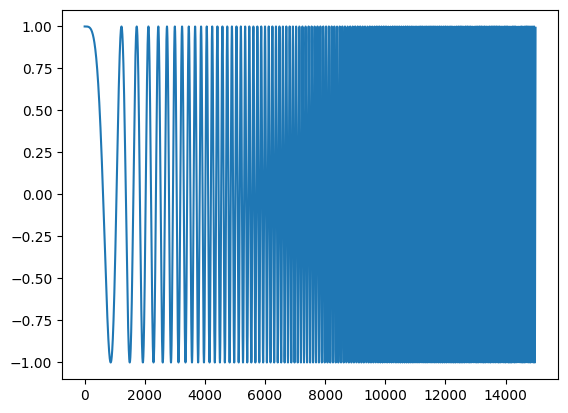

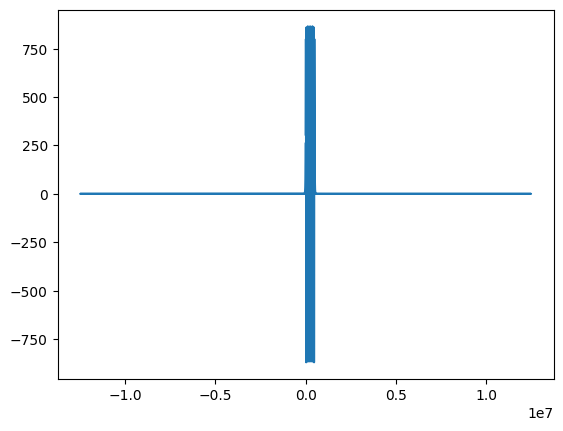

In [3]:
def generate_iq_at_freq(num_samples, freq, amplitude, sample_rate):
    t = np.linspace(0, num_samples / sample_rate, num_samples)
    I = amplitude * np.cos(2 * np.pi * freq * t)
    Q = amplitude * np.sin(2 * np.pi * freq * t)
    complex_data = I + 1j*Q
    return complex_data

def generate_iq_chirp(num_samples, start_freq, end_freq, amplitude, sample_rate):
    result = []
    for i in range(num_samples):
        t = i / sample_rate
        frequency = start_freq + (end_freq - start_freq) * i / num_samples
        phase = 2.0 * np.pi * frequency * t
        sample = amplitude * np.exp(1j * phase) + 0j 
        result.append(sample)
    return result

def spectrogram_data(complex_data, fs):
    # Compute the Short-Time Fourier Transform (STFT)
    nperseg = 256*8  # Number of samples per segment
    noverlap = nperseg // 8  # Number of overlapping samples
    frequencies, times, Zxx = stft(complex_data, fs=fs, nperseg=nperseg, noverlap=noverlap)


    # Shift the zero frequency component to the center
    Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
    frequencies_shifted = np.fft.fftshift(frequencies)

    # Compute the magnitude of the STFT
    magnitude_spectrogram = np.abs(Zxx_shifted)
    threshold_dB = 40
    threshold = 10**(threshold_dB / 20)  # Convert dB to linear scale

    magnitude_spectrogram_db = 20 * np.log10(magnitude_spectrogram)   
    return times, frequencies_shifted, magnitude_spectrogram_db


chirp_len = 15000
start_freq = 0
end_freq = 250e3
amplitude = 1
fs = 25e6
chirp_arr = generate_iq_chirp(chirp_len,start_freq,end_freq,amplitude,fs)
plt.plot(chirp_arr)
plt.show()
plt.plot(np.fft.fftfreq(len(chirp_arr),1/fs),np.fft.fft(chirp_arr))

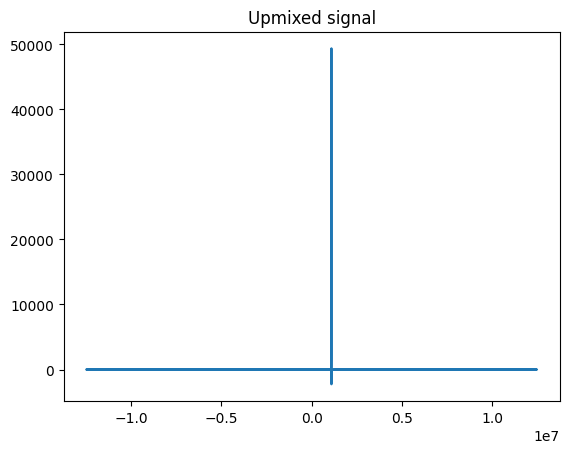

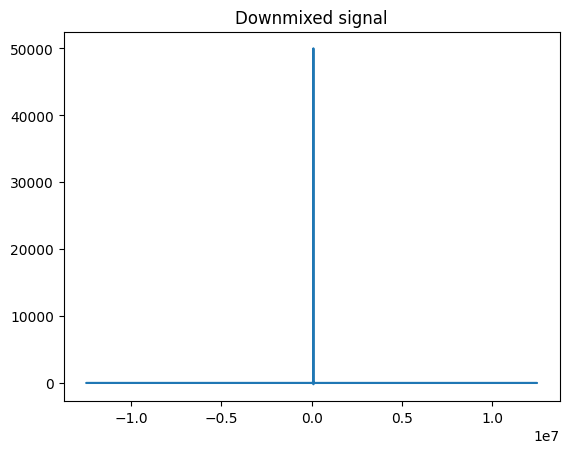

In [5]:

num_samples = 50000
# using smaller freqs
LO_freq = 1e6
BB_freq = 100e3
sample_rate = 25e6

# UPMIXING: LO freq, BB
LO_arr = generate_iq_at_freq(num_samples,LO_freq,1,sample_rate)
BB_arr = generate_iq_at_freq(num_samples,BB_freq,1,sample_rate)
upmixed = LO_arr*BB_arr
plt.plot(np.fft.fftfreq(len(upmixed),1/sample_rate),np.fft.fft(upmixed))
plt.title("Upmixed signal")
plt.show()

# DOWNMIXING
IF_arr = upmixed
downmixed = IF_arr*LO_arr.conjugate() # conjugate used in downmixing
plt.plot(np.fft.fftfreq(len(downmixed),1/sample_rate),np.fft.fft(downmixed))
plt.title("Downmixed signal")
plt.show()





First pulse is at index: 0.0
Echo pulse is at index: -24
td=-9.6e-07
d=-143.90037984


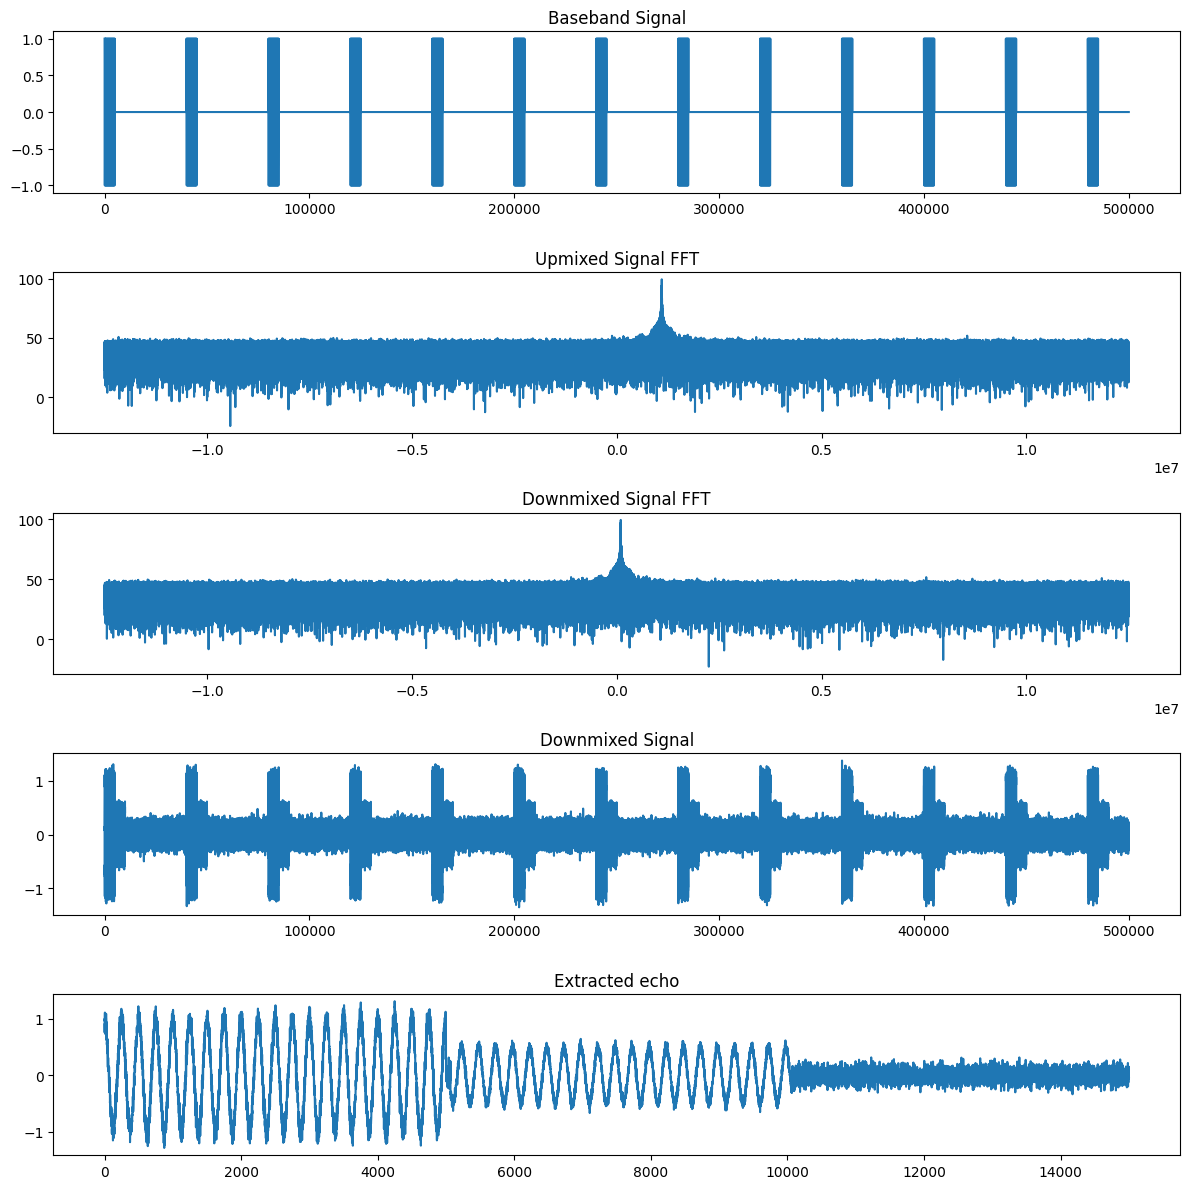

In [9]:
num_samples = 500000
# using smaller freqs
LO_freq = 1e6
BB_freq = 100e3
sample_rate = 25e6

# UPMIXING: LO freq, BB
LO_arr = generate_iq_at_freq(num_samples,LO_freq,1,sample_rate)
BB_arr = generate_iq_at_freq(num_samples,BB_freq,1,sample_rate)
# convert BB to pulsed
pulse_length = 5000
pulse_separation = 40000
prf = sample_rate/pulse_separation
num_pulses = 0
for i in range (pulse_length,len(BB_arr),pulse_separation):
    BB_arr[i:i+pulse_separation-pulse_length] = 0
    num_pulses += 1

upmixed = LO_arr*BB_arr

# add noise
noise_variance = 0.1
noise_i = np.random.normal(0, noise_variance, num_samples)
noise_q = np.random.normal(0, noise_variance, num_samples)
upmixed  += noise_i + 1j*noise_q

# insert echo
d = 1000
td = d/c
idx = int(td*sample_rate)
for i in range (pulse_length,len(upmixed),pulse_separation):
    upmixed[i+idx:i+idx+pulse_length] = 0.5*upmixed[0:pulse_length]


# DOWNMIXING
IF_arr = upmixed
downmixed = IF_arr*LO_arr.conjugate() # conjugate used in downmixing



template_pulse = BB_arr[0:pulse_length]
corr_end = pulse_length*2
corr = np.correlate(downmixed[0:corr_end], template_pulse, mode='same')
first_pulse_index = np.argmax(corr) - len(template_pulse)/2
print("First pulse is at index: " + str(first_pulse_index))

# extract segment
# TODO: upsample here to increase range resolution
pulse_end = int(first_pulse_index+len(template_pulse))
segment = downmixed[pulse_end:pulse_end+pulse_separation-pulse_length]

# now correlate template pulse with the segment to get the time delay
correlation_seg = np.correlate(segment, template_pulse, mode='full')
peak_index = np.argmax(correlation_seg) - (len(template_pulse)-1)
print("Echo pulse is at index: " + str(peak_index))
td = peak_index/sample_rate
d = td*c/2
# calculate time delay
print("td=" + str(td))
print("d=" + str(d))






# Plotting
fig, axs = plt.subplots(5, figsize=(12, 12))
#plt.subplots_adjust(hspace=0.5, wspace=0.5)

axs[0].plot(BB_arr)
axs[0].set_title('Baseband Signal')
#axs[0].grid(True)

axs[1].plot(np.fft.fftfreq(len(upmixed),1/sample_rate),20*np.log10(np.abs(np.fft.fft(upmixed))))
axs[1].set_title('Upmixed Signal FFT')
#axs[1].grid(True)

axs[2].plot(np.fft.fftfreq(len(downmixed),1/sample_rate),20*np.log10(np.abs(np.fft.fft(downmixed))))
axs[2].set_title('Downmixed Signal FFT')
#axs[2].grid(True)

axs[3].plot(downmixed)
axs[3].set_title('Downmixed Signal')

axs[4].plot(downmixed[0:int(corr_end*1.5)])
axs[4].set_title('Extracted echo')


plt.tight_layout()
plt.show()



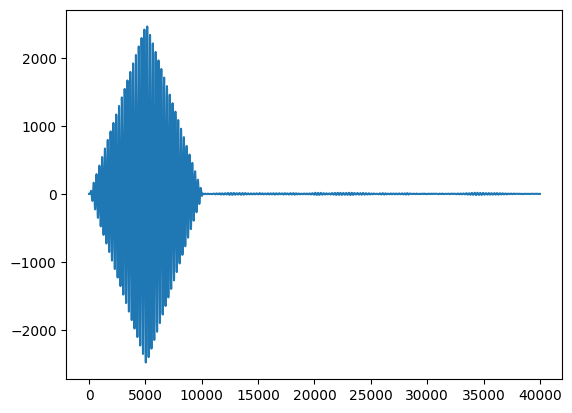

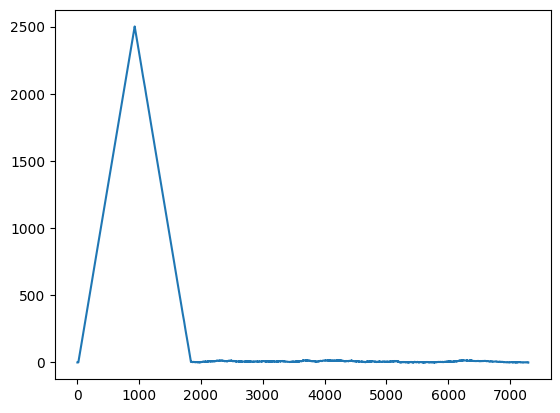

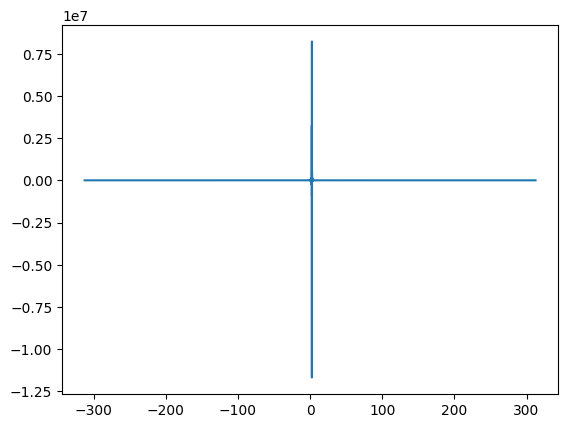

In [49]:
compressed_signal = signal.correlate(segment, template_pulse, mode='full')
plt.plot(compressed_signal)
plt.show()

range_bins = np.linspace(0, num_samples * c / (2 * prf * sample_rate) + pulse_length/2, pulse_separation-1) # TODO: investigate 
plt.plot(range_bins,np.abs(compressed_signal))
plt.show()


doppler_data = np.fft.fft(compressed_signal)
doppler_data = np.fft.fftshift(doppler_data)
T = 1/sample_rate
B = 1e6 # TODO:
df = 1 / (T*pulse_separation)  # Doppler frequency resolution
dr = c / (2 * B)  # Range resolution (where B is bandwidth)
doppler_axis = np.linspace(-df / 2, df / 2, pulse_separation-1)

plt.plot(doppler_axis,doppler_data)
plt.show()


First pulse is at index: 0.0


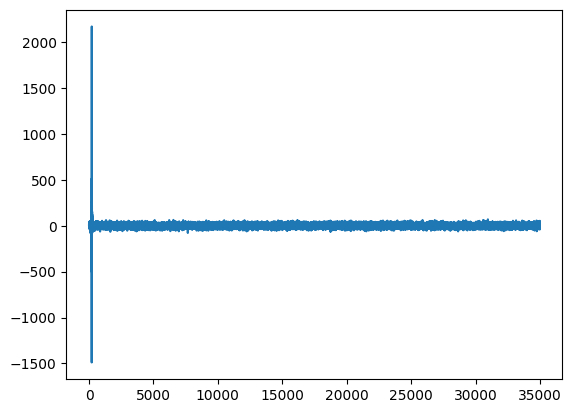

0.00018676


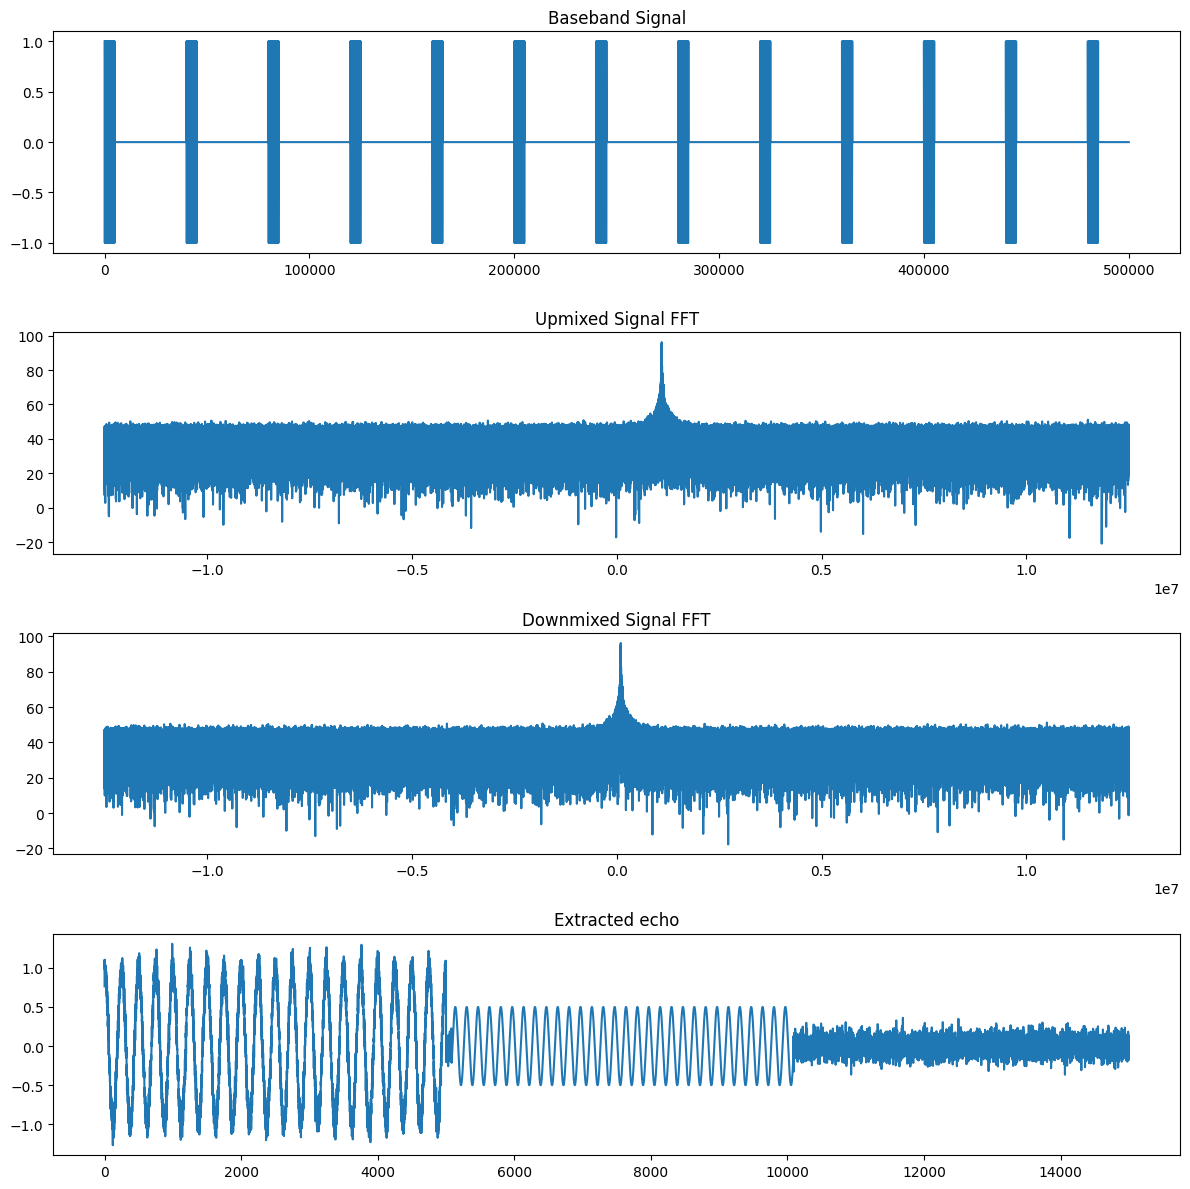

In [32]:
num_samples = 500000
# using smaller freqs
LO_freq = 1e6
BB_freq = 100e3
refl_freq = 150e3
sample_rate = 25e6

# UPMIXING: LO freq, BB
LO_arr = generate_iq_at_freq(num_samples,LO_freq,1,sample_rate)
BB_arr = generate_iq_at_freq(num_samples,BB_freq,1,sample_rate)
refl_arr = generate_iq_at_freq(num_samples,refl_freq,1,sample_rate)
# convert BB to pulsed
pulse_length = 5000
pulse_separation = 40000
prf = sample_rate/pulse_separation
num_pulses = 0
for i in range (pulse_length,len(BB_arr),pulse_separation):
    BB_arr[i:i+pulse_separation-pulse_length] = 0
    num_pulses += 1

upmixed = LO_arr*BB_arr

# add noise
noise_variance = 0.1
noise_i = np.random.normal(0, noise_variance, num_samples)
noise_q = np.random.normal(0, noise_variance, num_samples)
upmixed  += noise_i + 1j*noise_q

# insert echo
d = 1000
td = d/c
idx = pulse_length + int(td*sample_rate)
upmixed_refl = LO_arr*refl_arr
upmixed[idx:idx+pulse_length] = 0.5*upmixed_refl[0:pulse_length]

# DOWNMIXING
IF_arr = upmixed
downmixed = IF_arr*LO_arr.conjugate() # conjugate used in downmixing



template_pulse = BB_arr[0:pulse_length]
corr_end = pulse_length*2
corr = np.correlate(downmixed[0:corr_end], template_pulse, mode='same')
first_pulse_index = np.argmax(corr) - len(template_pulse)/2
print("First pulse is at index: " + str(first_pulse_index))

# extract segment
# TODO: upsample here to increase range resolution
pulse_end = int(first_pulse_index+len(template_pulse))
segment = downmixed[pulse_end:pulse_end+pulse_separation-pulse_length]


# now correlate template pulse with the segment to get the time delay
seg_fft = np.fft.fft(segment)
template_pulse = np.concatenate((template_pulse, np.zeros(30000))) # zero padding for same length, I think this may cause erros
template_fft = np.fft.fft(template_pulse)
cross_correlation = template_fft * np.conj(seg_fft)
time_domain_correlation = np.fft.ifft(cross_correlation)
plt.plot(seg_fft)
plt.show()
max_index = np.argmax(np.abs(time_domain_correlation))
time_delay = max_index / sample_rate
print(time_delay)

# Plotting
fig, axs = plt.subplots(4, figsize=(12, 12))
#plt.subplots_adjust(hspace=0.5, wspace=0.5)

axs[0].plot(BB_arr)
axs[0].set_title('Baseband Signal')
#axs[0].grid(True)

axs[1].plot(np.fft.fftfreq(len(upmixed),1/sample_rate),20*np.log10(np.abs(np.fft.fft(upmixed))))
axs[1].set_title('Upmixed Signal FFT')
#axs[1].grid(True)

axs[2].plot(np.fft.fftfreq(len(downmixed),1/sample_rate),20*np.log10(np.abs(np.fft.fft(downmixed))))
axs[2].set_title('Downmixed Signal FFT')
#axs[2].grid(True)

axs[3].plot(downmixed[0:int(corr_end*1.5)])
axs[3].set_title('Extracted echo')


plt.tight_layout()
plt.show()